In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [114]:
#%% notes
# all temperatures are Celsius except where stated otherwise (wind modeling)
# Solar:
# The solar model is deterministic and requires a base capacity factor (set to basecf=1 for demonstration purposes) as an input.
# The base capacity factor is a proxy for irradiance and can be sampled separately to model uncertainty.
# In the paper, this was selected by the scenario's hour of the year.

#%% data setup
# required data for conventional outages
rates = pd.read_csv('temperture_dependent_rates_linear.csv').set_index('Temp')
t_index = list(rates.index)
r = rates.to_dict()
basecf = 1 # base capacity factor for solar (irradiance proxy)

In [115]:
rates

,CC,CT,DS,HD,NU,ST
Temp,,,,,,
-50,0.625,0.899,0.506,0.259,0.026,0.280
-15,0.149,0.199,0.212,0.070,0.019,0.133
-10,0.081,0.099,0.170,0.043,0.018,0.112
-5,0.048,0.051,0.137,0.032,0.017,0.099
0,0.033,0.031,0.116,0.027,0.018,0.091
5,0.027,0.024,0.106,0.026,0.018,0.086
10,0.025,0.022,0.102,0.026,0.019,0.083
15,0.028,0.024,0.104,0.027,0.021,0.084
20,0.035,0.027,0.136,0.027,0.027,0.086


In [116]:
print(r['CC'], '\n', r['CC'][-50])

{-50: 0.625, -15: 0.149, -10: 0.081, -5: 0.048, 0: 0.033, 5: 0.027, 10: 0.025, 15: 0.028, 20: 0.035, 25: 0.035, 30: 0.041, 35: 0.072, 60: 0.227, 120: 0.227} 
 0.625


In [117]:
# relevant technology names from rates table
conventional = ['CC','CT','NU','ST','DS','HD']
# all technologies modeled
technologies = ['wind','solar'] + conventional
# names for printing
map_tech_name = {
    'wind': 'Wind',
    'solar': 'Solar',
    'CC': 'Combined Cycle',
    'CT': 'Combustion Turbine',
    'NU': 'Nuclear',
    'ST': 'Coal steam',
    'DS': 'Diesel',
    'HD': 'Hydro'
}

### Modeling Functions

Solar (deterministic)

In [118]:
# solar is deterministic given a temperature and base capacity factor
# the base capacity factor is a proxy for irradiance
# the function returns an adjusted capacity factor (Z)
def solarfunction(temperature,basecapacityfactor):
    NOCT = 45
    eff = .18
    eta = 0.005
    Z = 1 - (temperature + (NOCT - 20) / 800 * basecapacityfactor / eff - 25) * eta
    Z = min(1.0, Z)
    return Z

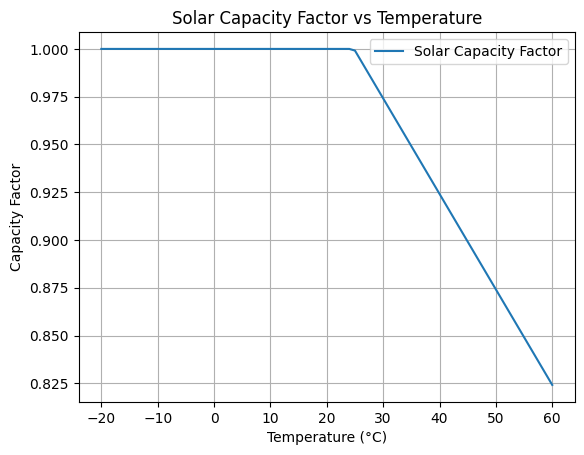

In [119]:
temperatures = np.arange(-20, 61, 1)
solar_capacity_factors = [solarfunction(temp, basecf) for temp in temperatures]
plt.plot(temperatures, solar_capacity_factors, label='Solar Capacity Factor')
plt.xlabel('Temperature (°C)')
plt.ylabel('Capacity Factor')
plt.title('Solar Capacity Factor vs Temperature')
plt.legend()
plt.grid(True)
plt.show()

wind (random within some range of temperatures)

In [120]:
# wind: only affects capacity between off and on temperatures
def windfunction(temperature):
    on = -20 # -20 Fahrenheit
    off = -30 # -30 Fahrenheit
    ratio = 0.1
    k = 0.1
    temperatureF = temperature * 9/5 + 32

    if temperatureF >= on:
        Z = 1
    elif temperatureF <= off:
        Z = 0
    else:
        q = getP_failure(temperatureF,on,off,ratio)
        Z = max(0, 1-np.random.normal(q, q*(1-q)*k))
        Z = min(1.0, Z)
    return Z

def getP_failure(t,on,off,ratio):
    dT = on-off
    b = -off+dT*ratio
    a = (off+b)*(on+b) / dT
    c = -a / (on+b)
    p_fail = a / (t + b) + c
    return p_fail

p_fail (or q(t))

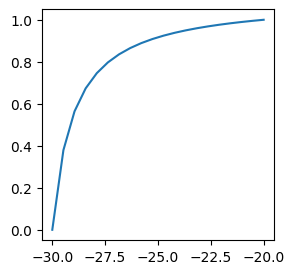

In [121]:
on = -20 # -20 Fahrenheit
off = -30 # -30 Fahrenheit
ratio = 0.1
k = 0.1
t = np.linspace(off,on,20)
plt.figure(figsize=(3,3))
plt.plot(t,[1-getP_failure(i,on,off,ratio) for i in t])


Plotting the density of the rv 1-np.random.normal(q, q*(1-q)*k) for different t's

[0.02475    0.02019379 0.0154628  0.01172959 0.0088396  0.00656926
 0.00475    0.00326424 0.00203019 0.00099   ]
[0.15732132722552272, 0.14210484503439186, 0.12434951856829236, 0.1083032401949946, 0.09401914698613255, 0.0810509887811488, 0.06892024376045114, 0.057133562585431646, 0.04505763379139254, 0.03146426544510456]


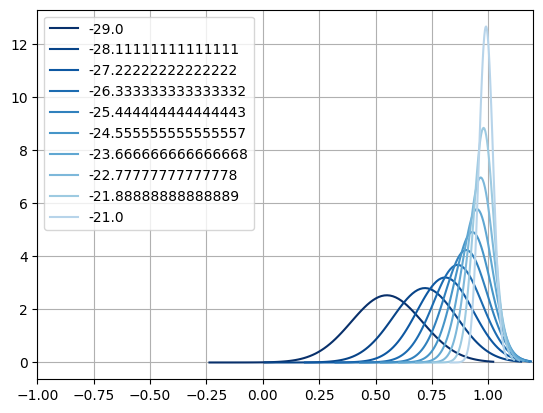

In [122]:
import scipy.stats as stats
import math

t = np.linspace(off+1,on-1,10)
q = np.array([getP_failure(i,on,off,ratio) for i in t])
mus = 1 - q
variances = q * (1-q) * k
print(variances)
sigmas = [math.sqrt(i) for i in variances]
print(sigmas)
x = [np.linspace(mus[i] - 5 * sigmas[i], mus[i] + 3 * sigmas[i], 100) for i in range(len(mus))]
colors = plt.cm.Blues(np.linspace(1, 0.3, len(mus)))
for i in range(len(mus)):
    plt.plot(x[i], stats.norm.pdf(x[i], mus[i], sigmas[i]), label=t[i], color=colors[i])
plt.legend(loc="upper left")
plt.xlim(-1,1.2)
plt.grid()
plt.show()

In [123]:
x = np.linspace(-1,1,10)
x

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])

In [124]:
x = np.linspace(0,1,100)
t = np.array([-35, -30, *np.linspace(off+1, on-1, 20), -20, -15])
Hists = np.zeros((len(x), len(t)))
# deterministic when outside the window [-30,-20]
Hists[0,[0,1]] = 18
Hists[-1,[-1,-2]] = 18
for i in range(len(t)-4):
    q = getP_failure(t[i+2],on,off,ratio)
    mu = 1 - q
    sigma = math.sqrt(q * (1-q) * k)
    Hists[:,i+2] = stats.norm.pdf(x, mu, sigma)


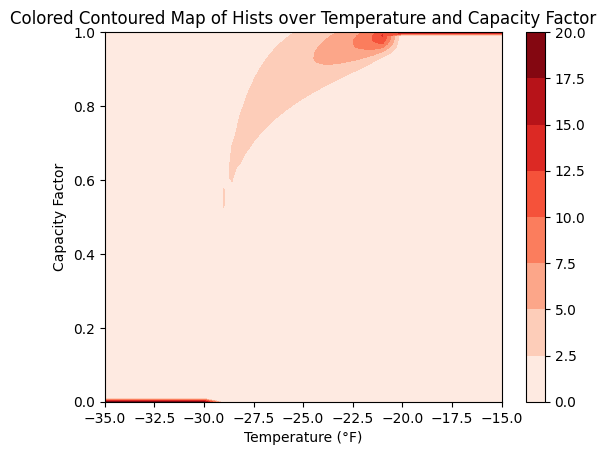

In [125]:
T, X = np.meshgrid(t, x)
contour = plt.contourf(T, X, Hists, cmap='Reds')
plt.colorbar(contour)
plt.xlabel('Temperature (°F)')
plt.ylabel('Capacity Factor')
plt.title('Colored Contoured Map of Hists over Temperature and Capacity Factor')
plt.show()

Conventional: Combined Cycle, Combustion Turbine, Nuclear, Coal steam, Diesel, Hydro

In [126]:
import random, bisect
# conventional: interpolates data in table (if necessary) to find outage rate at temperature
def conventionalfunction(temperature, technology):
    outagerate = t_interp(temperature,technology)
    prob = random.uniform(0,1)
    Z = int(prob >= outagerate)
    return Z, outagerate

def t_interp(t,tech):
    if t in t_index:
        return r[tech][t]
    else:
        b = bisect.bisect(t_index,t)
        low = t_index[b-1]
        high = t_index[b]
        return np.interp(t,(low,high),(r[tech][low],r[tech][high]))


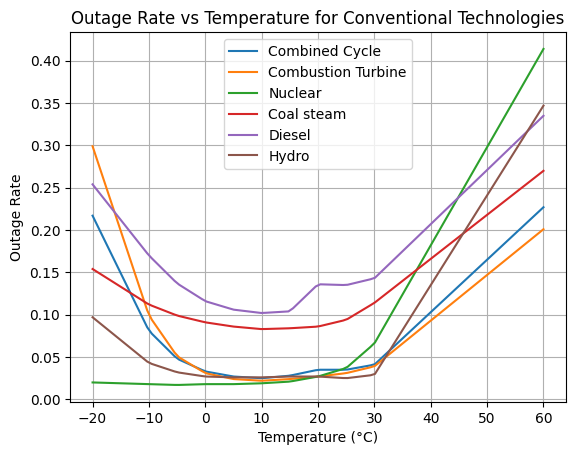

In [127]:
t = np.linspace(-20,60,100)
plt.xlabel('Temperature (°C)')
plt.ylabel('Outage Rate')
plt.title('Outage Rate vs Temperature for Conventional Technologies')
for tech in conventional:
    outagerate = np.zeros(len(t))
    plt.plot(t, [conventionalfunction(i,tech)[1] for i in t], label=map_tech_name[tech])

plt.legend()
plt.grid()


Next, we randomly pick 100 generators of different technologies at 1000 random temperatures, for each temperature we provide an empirical average of the sampled Z's

In [128]:
def getcapacityfactor(temperature,technology):
    if technology == 'solar':
        Z = solarfunction(temperature,basecf)
    elif technology == 'wind':
        Z = windfunction(temperature)
    elif technology in conventional:
        Z, _ = conventionalfunction(temperature,technology)
    return Z

In [129]:
technologies = ['wind','solar','CC','CT','NU','ST','DS','HD']
sample_technologies = random.choices(technologies, k=1000)


In [130]:
j = -1
sample_temperatures = np.random.uniform(-20, 60, 1000)
Zs = np.zeros(len(sample_technologies))
for tech in sample_technologies:
    j += 1
    Zs[j] = 0
    for temp in sample_temperatures:
        Zs[j] += getcapacityfactor(temp,tech)
    Zs[j] /= len(sample_temperatures)

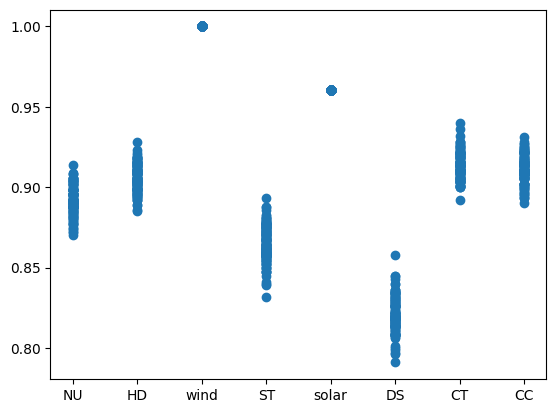

In [131]:
plt.scatter(sample_technologies, Zs)

Sampling the 6 temperature scenarios in WI

In [132]:
num_technologies = 500
num_temp_samples = 500
sample_technologies = random.choices(technologies, k=num_technologies)
temperature_scenarios = ((-54,-48),(1,7),(3.7,23.9),(57,82),(78,86),(108,114))
Zs = np.zeros((len(temperature_scenarios), num_technologies, num_temp_samples))
i = -1
for temp_scenario in temperature_scenarios:
    i += 1
    sample_temperatures = np.random.uniform(temp_scenario[0], temp_scenario[1], num_temp_samples)
    j = -1
    for tech in sample_technologies:
        j += 1
        Zs_for_one_gen = np.zeros(num_temp_samples)
        k = -1
        for temp_sample in sample_temperatures:
            k += 1
            Zs_for_one_gen[k] = getcapacityfactor(temp_sample, tech)
        Zs[i, j, :] = Zs_for_one_gen

Calculating the mean capacity factor over all generators and temperature samples

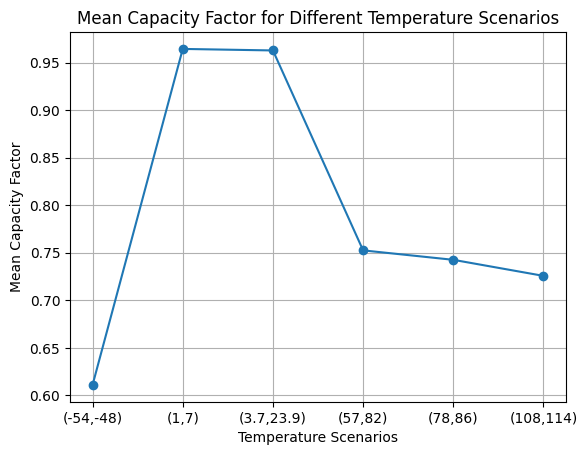

In [133]:
Zs_mean_over_samples = np.mean(Zs, axis=2)
Zs_mean_over_gens = np.mean(Zs_mean_over_samples, axis=1)
plt.plot(Zs_mean_over_gens, marker='o')
plt.xticks(ticks=np.arange(len(temperature_scenarios)), labels=[f"({low},{high})" for low, high in temperature_scenarios])
plt.xlabel('Temperature Scenarios')
plt.ylabel('Mean Capacity Factor')
plt.title('Mean Capacity Factor for Different Temperature Scenarios')
plt.grid(True)
plt.show()

Creating the histograms for each temperature scenario (over all generators and temperature samples)

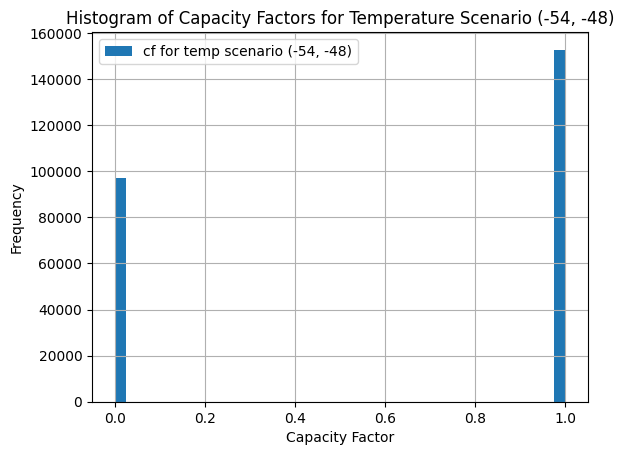

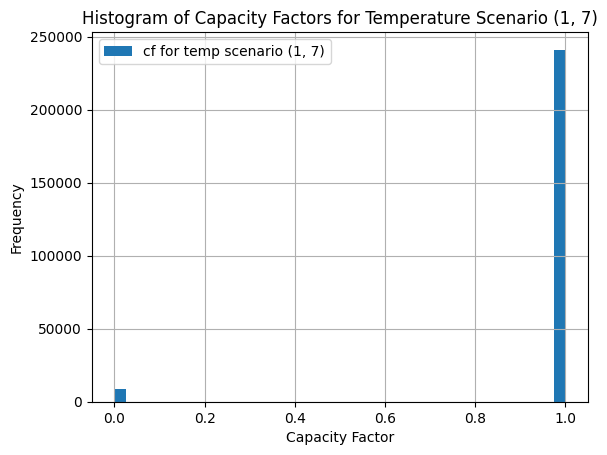

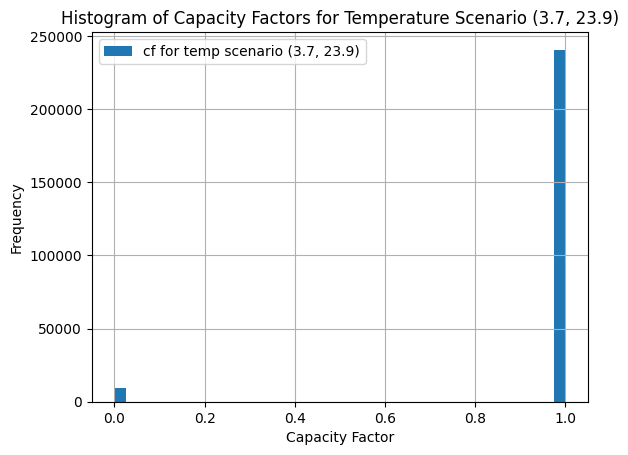

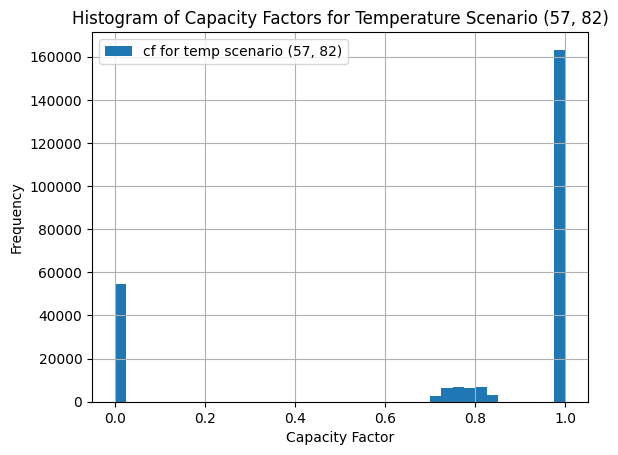

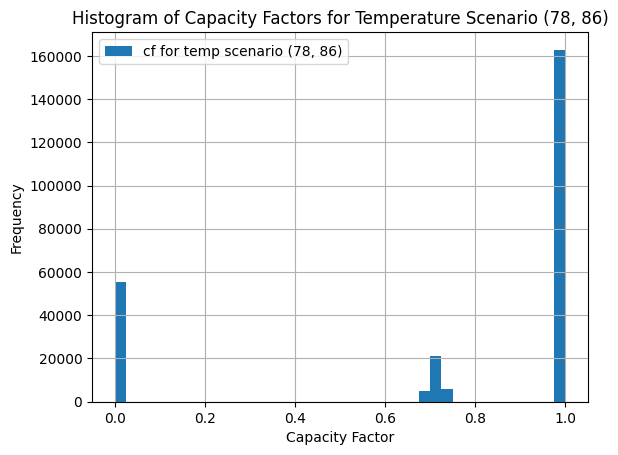

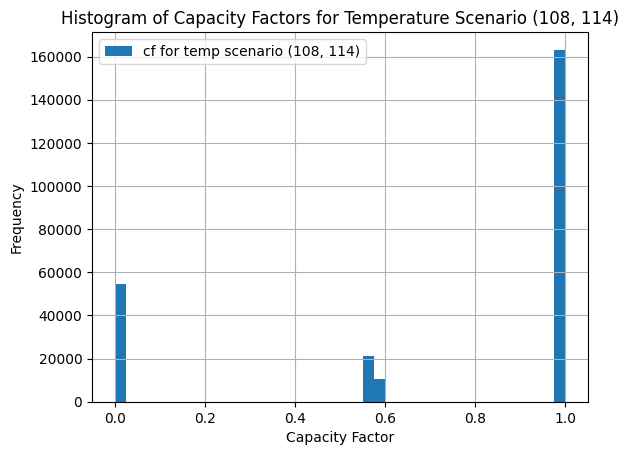

In [142]:
for i, temp_scenario in enumerate(temperature_scenarios):
    plt.figure()
    plt.hist(Zs[i,:,:].flatten(), bins=40, label=f'cf for temp scenario {temp_scenario}')
    plt.xlabel('Capacity Factor')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Capacity Factors for Temperature Scenario {temp_scenario}')
    plt.legend()
    plt.grid(True)
    plt.show()

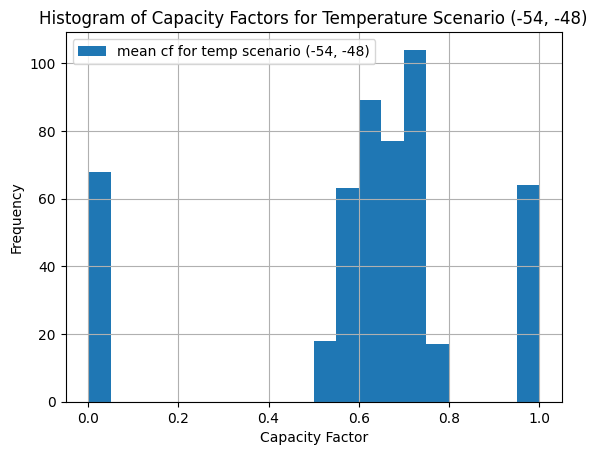

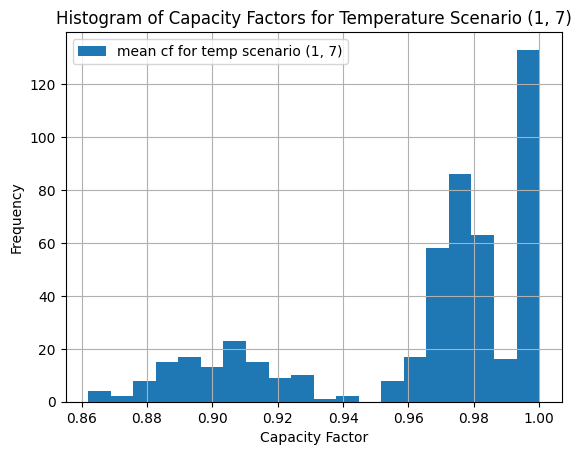

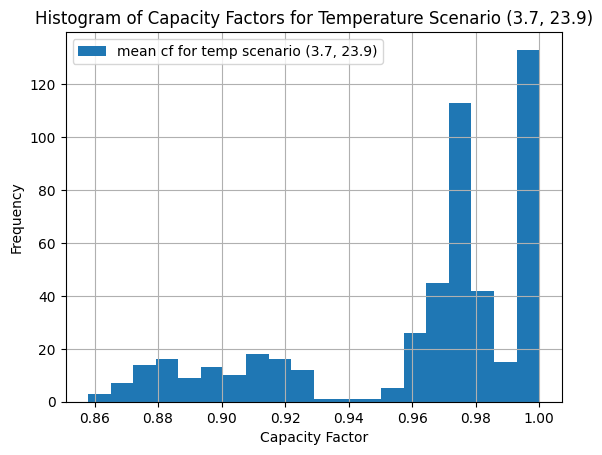

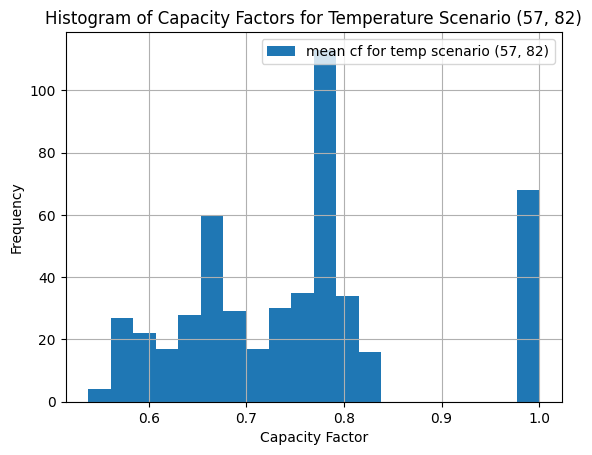

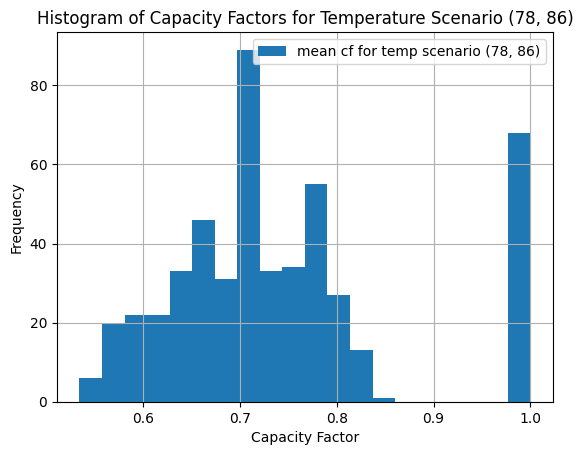

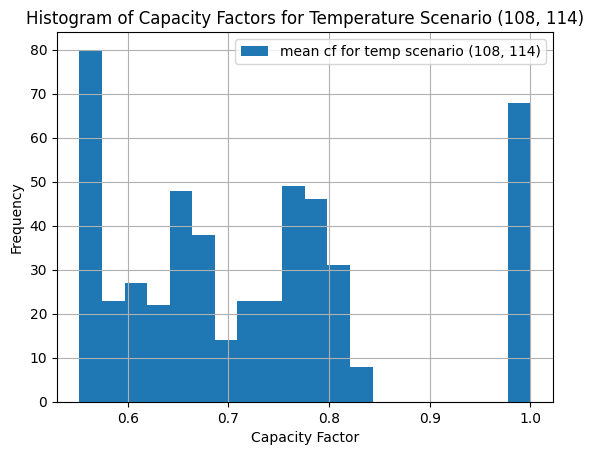

In [143]:
# Average Zs over the third dimension
Zs_mean_over_samples = np.mean(Zs, axis=2)

# Plot histograms for each temperature scenario (over all generators)
for i, temp_scenario in enumerate(temperature_scenarios):
    plt.figure()
    plt.hist(Zs_mean_over_samples[i, :], bins=20, label=f'mean cf for temp scenario {temp_scenario}')
    plt.xlabel('Capacity Factor')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Capacity Factors for Temperature Scenario {temp_scenario}')
    plt.legend()
    plt.grid(True)
    plt.show()